In [60]:
import pandas as pd 

In [61]:
df = pd.read_csv('modelselection.csv')
df

,dataModel,modelName,trainingTime,precision,recall,f1Score,dataFrameNo
0,countVectorizer+iDF,svm,17.888,0.860,0.820,0.828,df1
1,countVectorizer+iDF,lr,1.548,0.862,0.804,0.817,df2
2,countVectorizer+iDF,nb,1.640,0.806,0.806,0.805,df3
3,countVectorizer+iDF+chisquare,svm,11.132,0.858,0.820,0.827,df4
4,countVectorizer+iDF+chisquare,lr,1.023,0.861,0.802,0.814,df5
5,countVectorizer+iDF+chisquare,nb,0.473,0.836,0.831,0.830,df6
6,unCleanData+countVectorizer+iDF,svm,7.980,0.873,0.845,0.850,df7
7,unCleanData+countVectorizer+iDF,lr,1.103,0.869,0.818,0.829,df8
8,unCleanData+countVectorizer+iDF,nb,0.422,0.830,0.831,0.830,df9
9,ngram+hashingtf+iDF,svm,10.965,0.685,0.435,0.524,df10


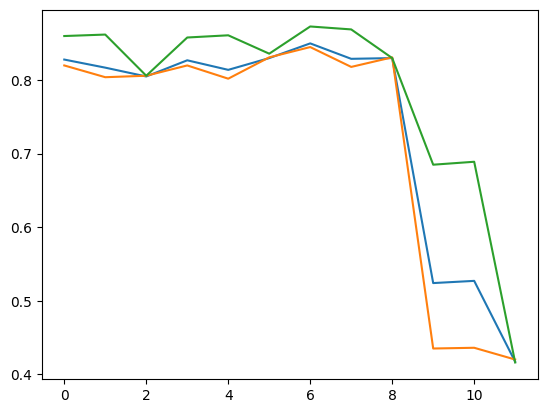

In [62]:
# plot multiple columns such as population and year from dataframe
import matplotlib.pyplot as plt 
# df.plot(x="dataFrameNo", y=["f1Score"],kind="line", figsize=(10, 10))
# df.plot(x="dataFrameNo", y=["recall"],kind="line", figsize=(10, 10))
plt.plot(df[["f1Score"]])
plt.plot(df[["recall"]])
plt.plot(df[["precision"]])
    

<AxesSubplot: xlabel='dataFrameNo'>

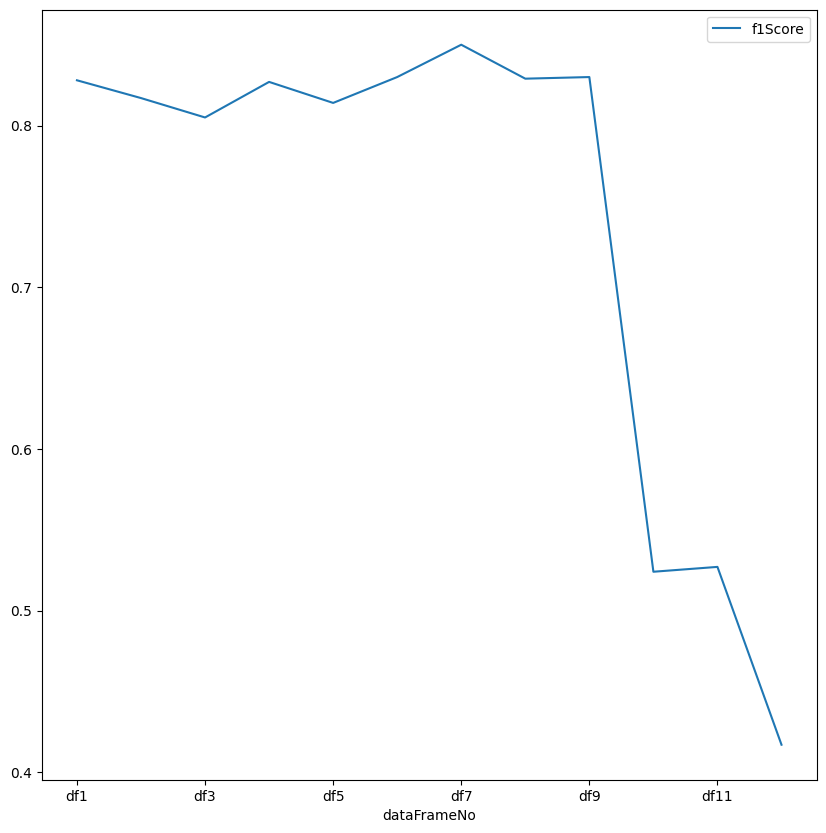

In [63]:
df.plot(x="dataFrameNo", y=["f1Score"],kind="line", figsize=(10, 10))


In [64]:
df.max()

dataModel       unCleanData+countVectorizer+iDF
modelName                                   svm
trainingTime                             17.888
precision                                 0.873
recall                                    0.845
f1Score                                    0.85
dataFrameNo                                 df9
dtype: object

<AxesSubplot: >

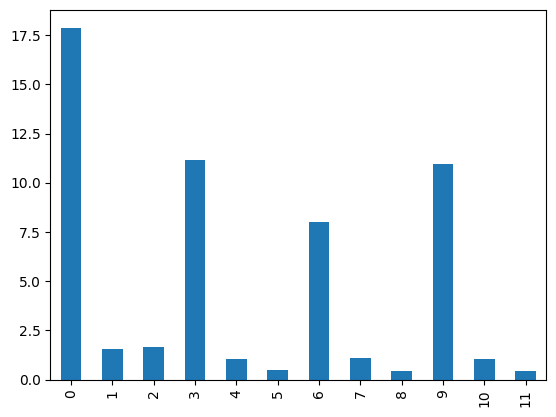

In [65]:
colours = {"unCleanData+countVectorizer+iDF": "#44bd32", "countVectorizer+iDF": "#44bd32", "ngram+hashingtf+iDF":"#273c75"}
df["trainingTime"].plot(kind="bar")

<AxesSubplot: xlabel='trainingTime', ylabel='modelName'>

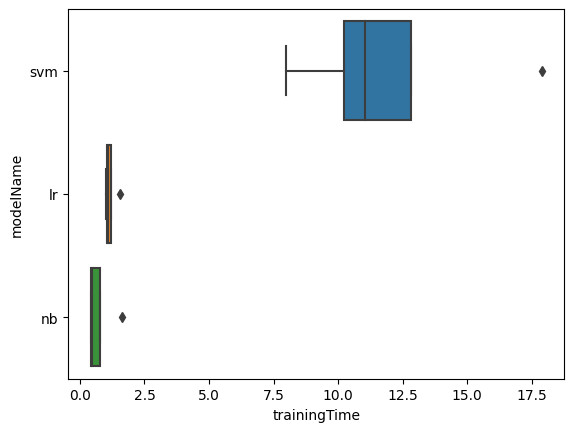

In [66]:
import seaborn as sns


sns.boxplot( x=df["trainingTime"], y=df["modelName"] )

<AxesSubplot: xlabel='trainingTime', ylabel='dataModel'>

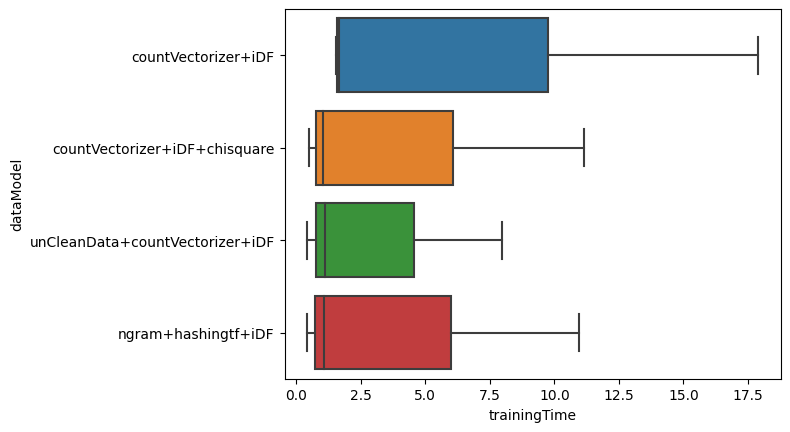

In [67]:

sns.boxplot( x=df["trainingTime"], y=df["dataModel"] )

In [4]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

# read the PySpark DataFrame from the Parquet file
df_training_m3 = spark.read.parquet("data/transformed_training_p3.parquet")
df_testing_m3 = spark.read.parquet("data/transformed_test_p3.parquet")
df_val_m3 = spark.read.parquet("data/transformed_val_p3.parquet")
df_training_m3.cache()
df_testing_m3.cache()
df_val_m3.cache()
print(df_val_m3.show(3))

# import time
classifier = LinearSVC(featuresCol = "featuresIDF", weightCol="weight", labelCol="label")
# Define OneVsRest strategy
ovr = OneVsRest(classifier=classifier, labelCol="label", featuresCol="featuresIDF", weightCol="weight")
pipeline = Pipeline(stages=[ovr])
# model = pipeline.fit(df_training_m3)


evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="f1")

# Define the hyperparameter grid
param_grid = ParamGridBuilder() \
    .addGrid(classifier.maxIter, [10, 50, 100]) \
    .addGrid(classifier.regParam,  [0.1, 0.01, 0.001])\
    .addGrid(classifier.weightCol, ['weight']) \
    .build()
#0.01, 0.1, 1.0
# Define the cross-validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

# Fit the cross-validator to the training set
cv_model = cv.fit(df_training_m3)

# Evaluate the best model on the validation set
best_model = cv_model.bestModel
predictions = best_model.transform(df_val_m3)
f1 = evaluator.evaluate(predictions)
print("f1 on validation set for best model:", f1)

# Evaluate the best model on the validation set
best_model = cv_model.bestModel
predictions2 = best_model.transform(df_testing_m3)
f2 = evaluator.evaluate(predictions)
print("f1 on validation set for best model:", f2)

+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+
|                text|emotion|label|              text_c|               words|         rawFeatures|         featuresIDF|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+
|im feeling quite ...|sadness|    1|  feel quite sad ...|[im, feeling, qui...|(1000,[2,7,8,11,1...|(1000,[2,7,8,11,1...|
|i feel like i am ...|sadness|    1|  feel like    st...|[i, feel, like, i...|(1000,[0,1,5,8,12...|(1000,[0,1,5,8,12...|
|i feel like a fai...|   love|    4|  feel like   fai...|[i, feel, like, a...|(1000,[0,1,5,12,6...|(1000,[0,1,5,12,6...|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

None


f1 on validation set for best model: 0.8520112013671158
f1 on validation set for best model: 0.8520112013671158


In [68]:
predictions = best_model.transform(df_testing_m3).cache()
predictionAndLabels = predictions.select("label","prediction").rdd.map(lambda x: (float(x[1]), float(x[0]))).cache()
# Calculate evaluation metrics
metrics = MulticlassMetrics(predictionAndLabels)

/home/hicran/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [82]:
precision = metrics.weightedPrecision
recall = metrics.weightedRecall
f1Score = metrics.weightedFMeasure(beta=1.0)
accuracy = metrics.accuracy
print(precision)

0.8677476693414614


In [69]:
labels = predictionAndLabels.map(lambda x: x[1]).distinct().collect()
confusion_matrix = metrics.confusionMatrix().toArray().astype(int)
print("Confusion matrix:")
print("Actual\Predicted\t", end="")
for label in labels:
    print(f"{label}\t\t", end="")
print("")
for i in range(len(labels)):
    print(f"{labels[i]}\t\t", end="")
    for j in range(len(labels)):
        print(f"{confusion_matrix[i][j]:<8}\t\t", end="")
    print("")

Confusion matrix:
Actual\Predicted	1.0		0.0		3.0		2.0		4.0		5.0		
1.0		667     		10      		4       		4       		8       		2       		
0.0		33      		537     		6       		2       		3       		0       		
3.0		30      		25      		219     		1       		0       		0       		
2.0		17      		19      		9       		178     		1       		0       		
4.0		64      		1       		2       		1       		90      		1       		
5.0		15      		1       		0       		17      		0       		33      		


In [70]:
# create dictionary to map numeric labels to string labels
label_map = {0:"Joy", 1: "sadness", 2: "anger",3:"fear", 4:"love", 5:"surprize"}
predicted_labels = predictionAndLabels.map(lambda x: x[0]).distinct().collect()
actual_labels = predictionAndLabels.map(lambda x: x[1]).distinct().collect()
# map numeric labels to string labels
predicted_labels = [label_map[label] for label in predicted_labels]
actual_labels = [label_map[label] for label in actual_labels]
# compute confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray().astype(int)
#print confusion matrix
print("Confusion matrix:")
print("Actual\Predicted\t", end="")
for label in predicted_labels:
    print(f"{label}\t\t", end="")
print("")
for i in range(len(actual_labels)):
    print(f"{actual_labels[i]}\t\t", end="")
    for j in range(len(predicted_labels)):
        print(f"{confusion_matrix[i][j]:<8}\t\t", end="")
    print("")

# # # compute and print class-wise precision, recall, and F1-score metrics
# for label in actual_labels:
#     precision = metrics.precision(label)
#     recall = metrics.recall(label)
#     f1_score = metrics.fMeasure(label, beta=1.0)
#     print(f"\nClass '{label}' metrics:")
#     print(f"Precision: {precision:.2f}")
#     print(f"Recall: {recall:.2f}")
#     print(f"F1-score: {f1_score:.2f}")

Confusion matrix:
Actual\Predicted	sadness		Joy		fear		anger		love		surprize		
sadness		667     		10      		4       		4       		8       		2       		
Joy		33      		537     		6       		2       		3       		0       		
fear		30      		25      		219     		1       		0       		0       		
anger		17      		19      		9       		178     		1       		0       		
love		64      		1       		2       		1       		90      		1       		
surprize		15      		1       		0       		17      		0       		33      		


In [73]:
# compute and print class-wise precision, recall, and F1-score metrics
for label in range(6):
    print(label_map[label])
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    # f1_score = metrics.fMeasure(label, beta=1.0)
    # print(f"\nClass '{label}' metrics:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(" ")
    # print(f"F1-score: {f1_score:.2f}")

Joy
Precision: 0.81
Recall: 0.96
 
sadness
Precision: 0.91
Recall: 0.92
 
anger
Precision: 0.91
Recall: 0.80
 
fear
Precision: 0.88
Recall: 0.79
 
love
Precision: 0.88
Recall: 0.57
 
surprize
Precision: 0.92
Recall: 0.50
 


In [3]:
sc.stop()


23/02/27 18:49:17 ERROR Instrumentation: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientSe